# Linear Support Vector Classifier

## Imports

In [3]:
import nltk
nltk.download('punkt')
import pandas as pd
# from google.colab import drive
from nltk.tokenize import word_tokenize
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn import svm
from sklearn.linear_model import SGDClassifier

from joblib import dump, load
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import itertools
import numpy as np

# fix random seed for reproducibility
seed = 42 

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/chuameiyun/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Data Loading

In [ ]:
drive.mount("/content/drive")
file_path = '/content/drive/MyDrive/CS4248/fulltrain.csv'

colnames=['Label', 'Text'] 
df = pd.read_csv(file_path, names=colnames, header=None)

Mounted at /content/drive


## Train-Test Split

In [ ]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
for train_index, test_valid_index in split.split(df, df.Label):
    train_set = df.iloc[train_index]
    test_valid_set = df.iloc[test_valid_index]

split2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
for test_index, valid_index in split2.split(test_valid_set, test_valid_set.Label):
    test_set = test_valid_set.iloc[test_index]
    valid_set = test_valid_set.iloc[valid_index]

In [ ]:
train_set['Label'].value_counts()

3    10722
1     8428
4     5997
2     4165
Name: Label, dtype: int64

In [ ]:
X_train = train_set['Text']
y_train = train_set['Label']

X_val = valid_set['Text']
y_val = valid_set['Label']

X_test = test_set['Text']
y_test = test_set['Label']

## Steps

Preprocessing 

Feature engineering (tfidf)

Model training

Prediction

Evaluation

In [4]:
# Building Model with pre-processing and feature engineering steps
class LanguageDetector():
    def __init__(self, classifier=MultinomialNB()):
        self.classifier = classifier
        self.vectorizer = TfidfVectorizer(lowercase=True, decode_error='ignore', preprocessor=self._preprocessing, ngram_range=(1,2))  # using Tfidf as feature engineering

    def _preprocessing(self, document):
        noise_pattern = re.compile("|".join(["http\S+", "\@\w+", "\#\w+"]))
        clean_text = re.sub(noise_pattern, "", document)
        return clean_text

    def features(self, X):
        return self.vectorizer.transform(X)

    def fit(self, X, y):
        self.vectorizer.fit(X) 
        self.classifier.fit(self.features(X), y)
    
    def predict_list(self, X):
        return self.classifier.predict(self.features(X))

    def predict_proba(self, X):
        return self.classifier.predict_proba(self.features(X))


    def predict(self, x):
        return self.classifier.predict(self.features([x]))


    def score(self, X, y):
        return self.classifier.score(self.features(X), y)

    def save_model(self, path):
        dump((self.classifier, self.vectorizer), path)

    def load_model(self, path):
        self.classifier, self.vectorizer = load(path)

Model Training

In [ ]:
%time
SVC_model = LanguageDetector(classifier = CalibratedClassifierCV(LinearSVC()))
SVC_model.fit(X_train, y_train)

CPU times: user 14 µs, sys: 0 ns, total: 14 µs
Wall time: 19.3 µs


In [ ]:
SVC_model.score(X_test, y_test)

0.9794289223211544

Model Prediction

In [ ]:
y_test_pred = SVC_model.predict_list(X_test)
y_test_pred_softmax = SVC_model.predict_proba(X_test)

Model Saving

In [ ]:
model_path = "SVC_model.model"
SVC_model.save_model(model_path)

Model Evaluation

f1 score

In [ ]:
target_names = ['class 0', 'class 1', 'class 2', 'class 3']
print(classification_report(y_test, y_test_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.98      0.98      0.98      2809
     class 1       0.98      0.98      0.98      1389
     class 2       0.98      0.99      0.98      3574
     class 3       0.98      0.96      0.97      1999

    accuracy                           0.98      9771
   macro avg       0.98      0.98      0.98      9771
weighted avg       0.98      0.98      0.98      9771



In [ ]:
from sklearn import metrics
print(f"F1: {metrics.f1_score(y_test,y_test_pred, average='macro')}")
print(f"Accuracy: {metrics.accuracy_score(y_test,y_test_pred)}")

F1: 0.9787321903494659
Accuracy: 0.9794289223211544


In [ ]:
conf_mat = confusion_matrix(y_test, y_test_pred)
print(conf_mat)

[[2749    9   28   23]
 [   2 1360   21    6]
 [  11   16 3532   15]
 [  38    0   32 1929]]


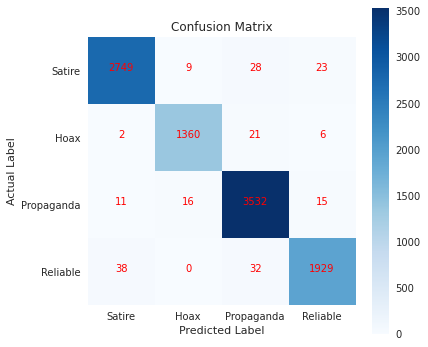

In [ ]:
with plt.style.context(('ggplot', 'seaborn')):
    fig = plt.figure(figsize=(6,6), num=1)
    plt.imshow(conf_mat, interpolation='nearest',cmap= plt.cm.Blues )
    plt.xticks([0,1,2,3],['Satire', 'Hoax', 'Propaganda', 'Reliable'])
    plt.yticks([0,1,2,3],['Satire', 'Hoax', 'Propaganda', 'Reliable'])
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    for i, j in itertools.product(range(conf_mat.shape[0]), range(conf_mat.shape[1])):
                plt.text(j, i,conf_mat[i, j], horizontalalignment="center",color="red")
    plt.grid(None)
    plt.title('Confusion Matrix')
    plt.colorbar();